# Regularization and Gradient Descent Exercises
![UnderOverFit.png](Assets/UnderOverFit.png)


# Learning Objectives

- Explain cost functions, regularization, feature selection, and hyper-parameters
- Summarize complex statistical optimization algorithms like gradient descent and its application to linear regression
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware

# scikit-learn*

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written.

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed.

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems.

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code prior to importing sklearn:

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions


## Introduction

We will begin with a short tutorial on regression, polynomial features, and regularization based on a very simple, sparse data set that contains a column of `x` data and associated `y` noisy data. The data file is called `X_Y_Sinusoid_Data.csv`.

In [7]:

import sklearn
from __future__ import print_function
import os
data_path = ['/content/']


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler


In [3]:
!pip install scikit-learn

## Question 1

* Import the data.

* Also generate approximately 100 equally spaced x data points over the range of 0 to 1. Using these points, calculate the y-data which represents the "ground truth" (the real function) from the equation: $y = sin(2\pi x)$

* Plot the sparse data (`x` vs `y`) and the calculated ("real") data.


In [8]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['X_Y_Sinusoid_Data.csv'])
data = pd.read_csv(filepath)

X_real = np.linspace(0, 1.0, 100)
Y_real = np.sin(2 * np.pi * X_real)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

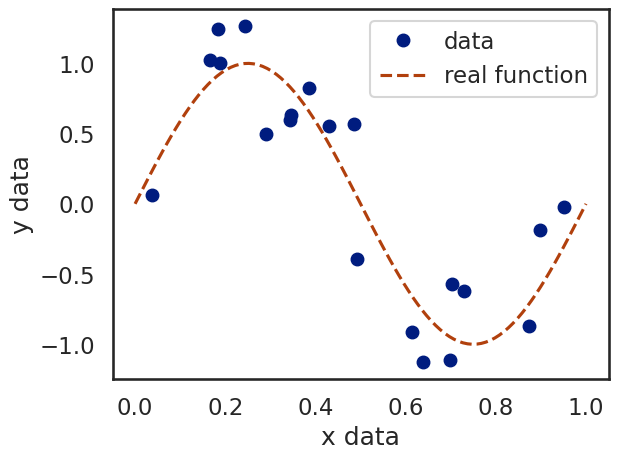

In [10]:
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('dark')

# Plot of the noisy (sparse)
ax = data.set_index('x')['y'].plot(ls='', marker='o', label='data')
ax.plot(X_real, Y_real, ls='--', marker='', label='real function')

ax.legend()
ax.set(xlabel='x data', ylabel='y data');

## Question 2


* Using the `PolynomialFeatures` class from Scikit-learn's preprocessing library, create 20th order polynomial features.
* Fit this data using linear regression.
* Plot the resulting predicted value compared to the calculated data.

Note that `PolynomialFeatures` requires either a dataframe (with one column, not a Series) or a 2D array of dimension (`X`, 1), where `X` is the length.

In [11]:
# Setup the polynomial features
degree = 20
pf = PolynomialFeatures(degree)
lr = LinearRegression()


## Question 3

* Perform the regression on using the data with polynomial features using ridge regression ($\alpha$=0.001) and lasso regression ($\alpha$=0.0001).
* Plot the results, as was done in Question 1.
* Also plot the magnitude of the coefficients obtained from these regressions, and compare them to those obtained from linear regression in the previous question. The linear regression coefficients will likely need a separate plot (or their own y-axis) due to their large magnitude.

What does the comparatively large magnitude of the data tell you about the role of regularization?

In [12]:
# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')


In [13]:
# let's look at the absolute value of coefficients for each model

coefficients = pd.DataFrame()
#update coefficients with all models

#describe coefficients
# Huge difference in scale between non-regularized vs regularized regression

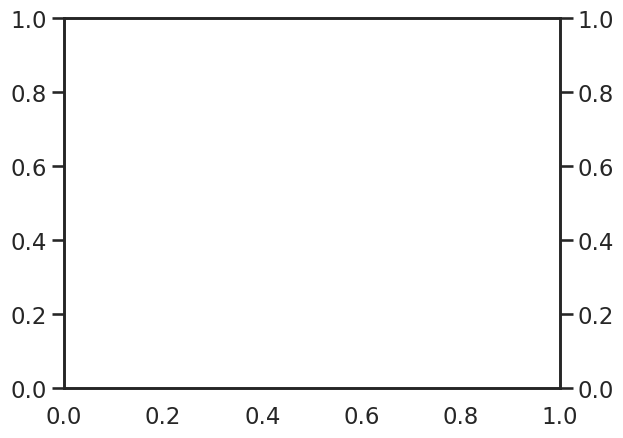

In [15]:
colors = sns.color_palette('dark')

# Setup the dual y-axes
ax1 = plt.axes()
ax2 = ax1.twinx()



## Question 4

For the remaining questions, we will be working with the [data set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) from last lesson, which is based on housing prices in Ames, Iowa. There are an extensive number of features--see the exercises from week three for a discussion of these features.

To begin:

* Import the data with Pandas, remove any null values, and one hot encode categoricals. Either Scikit-learn's feature encoders or Pandas `get_dummies` method can be used.
* Split the data into train and test sets.
* Log transform skewed features.
* Scaling can be attempted, although it can be interesting to see how well regularization works without scaling features.

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from scipy.stats import skew

In [17]:
filepath = os.sep.join(data_path + ['Ames_Housing_Sales.csv'])
data1 = pd.read_csv(filepath, sep=',')
data = data1.dropna()

Create a list of categorial data and one-hot encode. Pandas one-hot encoder (`get_dummies`) works well with data that is defined as a categorical.

In [20]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
onehot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
transformers = [('onehot', onehot_enc, categorical_cols)]
ct = ColumnTransformer(transformers=transformers, remainder='passthrough')
data_encoded = ct.fit_transform(data)

Next, split the data in train and test data sets.

In [21]:
X = data_encoded[:, :-1] # Features
y = data_encoded[:, -1] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

There are a number of columns that have skewed features--a log transformation can be applied to them. Note that this includes the `SalePrice`, our predictor. However, let's keep that one as is.

In [22]:
# Create a list of float colums to check for skewing
skewed_cols = data.select_dtypes(include=['float64']).columns.tolist()
for col in skewed_cols:
    data[col] = np.log1p(data[col])

Transform all the columns where the skew is greater than 0.75, excluding "SalePrice".

In [25]:
# OPTIONAL: Let's look at what happens to one of these features, when we apply np.log1p visually.
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
skewed_cols = [col for col in numeric_cols if col != 'SalePrice' and skew(data[col]) > 0.75]


In [26]:

for col in skewed_cols:
    data[col] = np.log1p(data[col])


In [27]:
data_encoded = ct.fit_transform(data)
X_log_transformed = data_encoded[:, :-1]
y_log_transformed = data_encoded[:, -1]
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_transformed, y_log_transformed, test_size=0.2, random_state=42)


## Question 5

* Write a function **`rmse`** that takes in truth and prediction values and returns the root-mean-squared error. Use sklearn's `mean_squared_error`.  


In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    """
    Calculate the root mean squared error (RMSE) between truth and prediction values.

    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values

    Returns:
    - rmse_score: float, root mean squared error
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse_score = np.sqrt(mse)
    return rmse_score

In [29]:
# Assuming y_true and y_pred are your true and predicted values
y_true = [1, 2, 3, 4, 5]
y_pred = [1.1, 2.2, 3.3, 4.4, 5.5]

# Calculate RMSE
print(rmse(y_true, y_pred))

0.3316624790355401


* Fit a basic linear regression model
* print the root-mean-squared error for this model
* plot the predicted vs actual sale price based on the model.  

<ipython-input-33-3838723ab2c8>:10: RuntimeWarning: overflow encountered in expm1
  y_pred = np.expm1(y_pred_log)


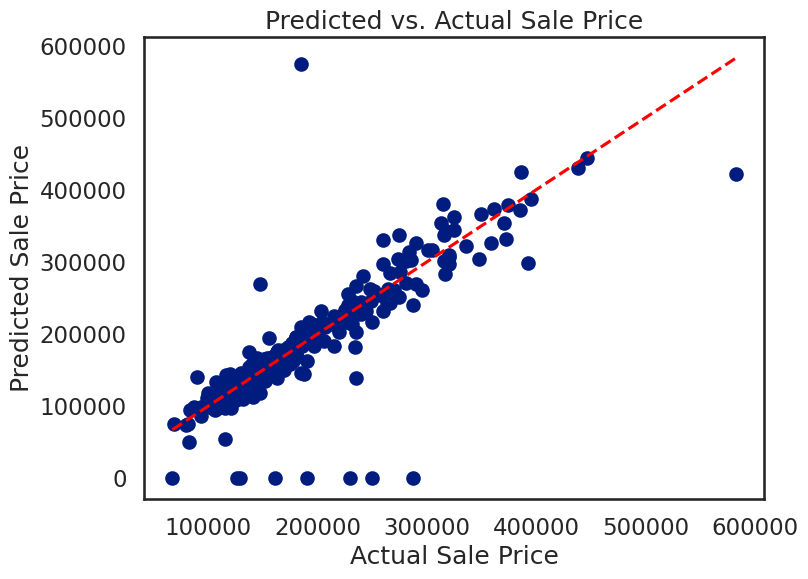

In [33]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train_log, y_train_log)

# Predict on the test set
# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)


# Plot predicted vs. actual sale price
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.title('Predicted vs. Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()


## Question 6

Ridge regression uses L2 normalization to reduce the magnitude of the coefficients. This can be helpful in situations where there is high variance. The regularization functions in Scikit-learn each contain versions that have cross-validation built in.

* Fit a regular (non-cross validated) Ridge model to a range of $\alpha$ values and plot the RMSE using the cross validated error function you created above.
* Use $$[0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]$$ as the range of alphas.
* Then repeat the fitting of the Ridge models using the range of $\alpha$ values from the prior section. Compare the results.

Now for the `RidgeCV` method. It's not possible to get the alpha values for the models that weren't selected, unfortunately. The resulting error values and $\alpha$ values are very similar to those obtained above.

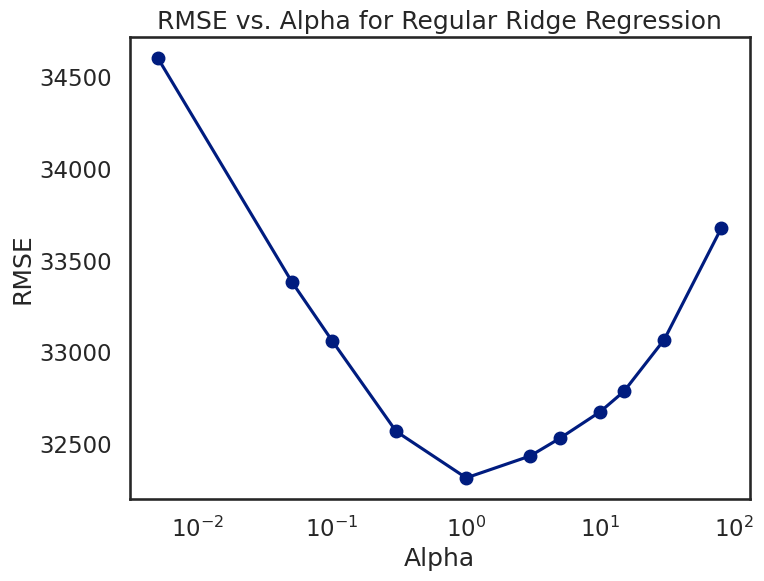

In [34]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Define a range of alpha values
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

# Fit regular Ridge models to the range of alpha values
rmse_scores = []
for alpha in alphas:
    # Fit the Ridge model
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_log, y_train_log)

    # Predict on the test set
    y_pred_log = ridge_model.predict(X_test_log)

    # Convert predictions back to original scale
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)

    # Calculate RMSE
    rmse_score = rmse(y_true, y_pred)
    rmse_scores.append(rmse_score)

# Plot RMSE vs. alpha
plt.figure(figsize=(8, 6))
plt.plot(alphas, rmse_scores, marker='o')
plt.title('RMSE vs. Alpha for Regular Ridge Regression')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


## Question 7


Much like the `RidgeCV` function, there is also a `LassoCV` function that uses an L1 regularization function and cross-validation. L1 regularization will selectively shrink some coefficients, effectively performing feature elimination.

The `LassoCV` function does not allow the scoring function to be set. However, the custom error function (`rmse`) created above can be used to evaluate the error on the final model.

Similarly, there is also an elastic net function with cross validation, `ElasticNetCV`, which is a combination of L2 and L1 regularization.

* Fit a Lasso model using cross validation and determine the optimum value for $\alpha$ and the RMSE using the function created above. Note that the magnitude of $\alpha$ may be different from the Ridge model.
* Repeat this with the Elastic net model.
* Compare the results via table and/or plot.

Use the following alphas:  
`[1e-5, 5e-5, 0.0001, 0.0005]`

In [35]:
from sklearn.linear_model import LassoCV, ElasticNetCV
import pandas as pd

# Define a range of alpha values for Lasso and ElasticNet
alphas_lasso = [1e-5, 5e-5, 0.0001, 0.0005]
alphas_elasticnet = [1e-5, 5e-5, 0.0001, 0.0005]

# Fit Lasso model using cross-validation
lasso_model = LassoCV(alphas=alphas_lasso, cv=5)
lasso_model.fit(X_train_log, y_train_log)

# Predict on the test set
y_pred_log_lasso = lasso_model.predict(X_test_log)

# Convert predictions back to original scale
y_pred_lasso = np.expm1(y_pred_log_lasso)
y_true_lasso = np.expm1(y_test_log)

# Calculate RMSE for Lasso
rmse_lasso = rmse(y_true_lasso, y_pred_lasso)

# Fit ElasticNet model using cross-validation
elasticnet_model = ElasticNetCV(alphas=alphas_elasticnet, l1_ratio=0.5, cv=5)
elasticnet_model.fit(X_train_log, y_train_log)

# Predict on the test set
y_pred_log_elasticnet = elasticnet_model.predict(X_test_log)

# Convert predictions back to original scale
y_pred_elasticnet = np.expm1(y_pred_log_elasticnet)
y_true_elasticnet = np.expm1(y_test_log)

# Calculate RMSE for ElasticNet
rmse_elasticnet = rmse(y_true_elasticnet, y_pred_elasticnet)

# Create a comparison table
results = pd.DataFrame({
    'Model': ['Lasso', 'ElasticNet'],
    'Optimal Alpha': [lasso_model.alpha_, elasticnet_model.alpha_],
    'RMSE': [rmse_lasso, rmse_elasticnet]
})

print("Results:\n", results)


Results:
         Model  Optimal Alpha          RMSE
0       Lasso         0.0005  33870.204381
1  ElasticNet         0.0005  33483.289665


We can determine how many of these features remain non-zero.

In [36]:
# Number of non-zero coefficients for Lasso
non_zero_features_lasso = np.sum(lasso_model.coef_ != 0)

# Number of non-zero coefficients for ElasticNet
non_zero_features_elasticnet = np.sum(elasticnet_model.coef_ != 0)

print("Number of non-zero features for Lasso:", non_zero_features_lasso)
print("Number of non-zero features for ElasticNet:", non_zero_features_elasticnet)


Number of non-zero features for Lasso: 105
Number of non-zero features for ElasticNet: 145


Now try the elastic net, with the same alphas as in Lasso, and l1_ratios between 0.1 and 0.9

In [37]:
# Define a range of l1_ratios
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

# Fit ElasticNet model with cross-validation for each l1_ratio
elasticnet_models = []
for l1_ratio in l1_ratios:
    elasticnet_model = ElasticNetCV(alphas=alphas_lasso, l1_ratio=l1_ratio, cv=5)
    elasticnet_model.fit(X_train_log, y_train_log)
    elasticnet_models.append(elasticnet_model)

# Predict on the test set for each ElasticNet model
y_pred_log_elasticnet = [model.predict(X_test_log) for model in elasticnet_models]

# Convert predictions back to original scale for each ElasticNet model
y_pred_elasticnet = [np.expm1(y_pred) for y_pred in y_pred_log_elasticnet]
y_true_elasticnet = np.expm1(y_test_log)

# Calculate RMSE for each ElasticNet model
rmse_elasticnet = [rmse(y_true_elasticnet, y_pred) for y_pred in y_pred_elasticnet]

# Create a comparison table
results_elasticnet = pd.DataFrame({
    'l1_ratio': l1_ratios,
    'Optimal Alpha': [model.alpha_ for model in elasticnet_models],
    'RMSE': rmse_elasticnet,
    'Non-Zero Features': [np.sum(model.coef_ != 0) for model in elasticnet_models]
})

print("Results for ElasticNet:\n", results_elasticnet)


Results for ElasticNet:
    l1_ratio  Optimal Alpha          RMSE  Non-Zero Features
0       0.1         0.0005  32952.957908                213
1       0.3         0.0005  33371.675657                167
2       0.5         0.0005  33483.289665                145
3       0.7         0.0005  33594.784084                127
4       0.9         0.0005  33760.360195                109


Comparing the RMSE calculation from all models is easiest in a table.

We can also make a plot of actual vs predicted housing prices as before.

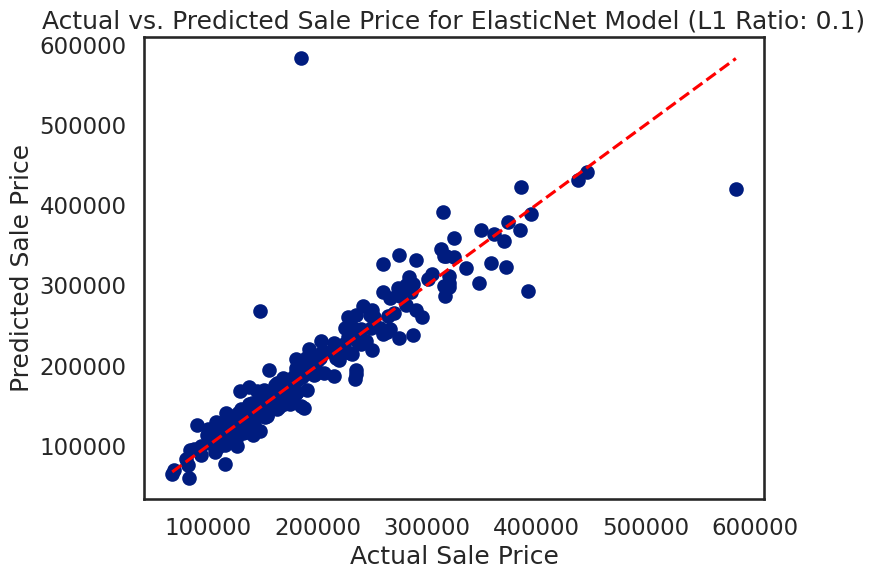

In [41]:
# Plot actual vs. predicted sale price for ElasticNet model
plt.figure(figsize=(8, 6))
plt.scatter(y_true_elasticnet, y_pred_elasticnet[0])  # Using the first ElasticNet model's predictions
plt.plot([min(y_true_elasticnet), max(y_true_elasticnet)], [min(y_true_elasticnet), max(y_true_elasticnet)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Sale Price for ElasticNet Model (L1 Ratio: {})'.format(l1_ratios[0]))
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()


## Question 8

Let's explore Stochastic gradient descent in this exercise.  
Recall that Linear models in general are sensitive to scaling.
However, SGD is *very* sensitive to scaling.  
Moreover, a high value of learning rate can cause the algorithm to diverge, whereas a too low value may take too long to converge.

* Fit a stochastic gradient descent model without a regularization penalty (the relevant parameter is `penalty`).
* Now fit stochastic gradient descent models with each of the three penalties (L2, L1, Elastic Net) using the parameter values determined by cross validation above.
* Do not scale the data before fitting the model.  
* Compare the results to those obtained without using stochastic gradient descent.

Notice how high the error values are! The algorithm is diverging. This can be due to scaling and/or learning rate being too high. Let's adjust the learning rate and see what happens.

* Pass in `eta0=1e-7` when creating the instance of `SGDClassifier`.
* Re-compute the errors for all the penalties and compare.

Now let's scale our training data and try again.

* Fit a `MinMaxScaler` to `X_train` create a variable `X_train_scaled`.
* Using the scaler, transform `X_test` and create a variable `X_test_scaled`.
* Apply the same versions of SGD to them and compare the results. Don't pass in a eta0 this time.

In [ ]:
scaler = MinMaxScaler()
